<a href="https://colab.research.google.com/github/iptishadugtal/SENTIMENT-POLARITY-DETECTION-AND-TOPIC-MODELLING/blob/main/Bidirectional_lstm_and_emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import keras
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.layers import *
from sklearn.model_selection import cross_val_score
import nltk
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df=pd.read_csv('/content/final.csv',nrows=3000)
# The isear.csv contains rows with value 'No response'
# We need to remove such rows

print(df.head())

   id                                            comment  sentiment  \
0   1  ye song nahi hi ye modi ji ka mehnat ka rang h...          2   
1   3  love u sir love u soo much urs i'ts beautyful ...          2   
2   4  arae sur jee pahelae hamare bharat ke bachho k...          1   
3   5  wah! jitni sundar geet ke bhao hain utnihi sun...          2   
4   8  sundar ekdam sahi gaya hua gana.chhotisi gudiy...          2   

   sentiment_pred                                     Processed Data  
0               2  Not only this song, this is the color of Modi ...  
1               2  love u sir love u soo much urs i'ts beautyful ...  
2               1  Before RA Sur Ji India or Bacho Ka Parao .... ...  
3               2  HeThe beautiful songs of the beautiful song ar...  
4               2                          Beautiful is perfect gan.  


In [ ]:
import nltk
nltk.download('punkt_tab')
Sentences = df['Processed Data']
Sentiments = df['sentiment']
feel_arr = [word_tokenize(sent) for sent in Sentences]
# Print the tokenized words of the first sentence
print(feel_arr[0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['Not', 'only', 'this', 'song', ',', 'this', 'is', 'the', 'color', 'of', 'Modi', 'ji', "'s", 'mother', ',', 'that', 'one', 'day', ',', 'the', 'whole', 'world', 'looks', ',', 'this', 'is', 'only', 'Turkmenistan.He', 'is', '..', 'Great', 'Modi', 'ji']


In [ ]:
glove ='/content/glove.6B.50d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

Glove = load_glove_embeddings(glove)

In [ ]:
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors a and b.
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))



In [ ]:
def preprocess(Sentences):
    sentences = tf.strings.substr(Sentences, 0, 300)
    sentences = tf.strings.regex_replace(sentences, b"<br\\s*/?>", b" ")
    sentences = tf.strings.regex_replace(sentences, b"[^a-zA-Z']", b" ")
    sentences = tf.strings.split(sentences)
    sentences = tf.strings.lower(sentences)
    sentences = sentences.to_tensor(default_value=b"<pad>")
    return sentences

In [ ]:
sentences = preprocess(Sentences)
sentences.shape

TensorShape([3000, 98])

In [ ]:
def encoding(sentences, Glove):
    i=0
    Encoded_vec = []

    for sentence in sentences:
        i=i+1
        print(i)
        sent_vec = []
        for token in sentence:
            if isinstance(token, tf.Tensor):
                token = token.numpy()  # Convert to numpy array

            if isinstance(token, bytes):
                token = token.decode('utf-8')
            elif not isinstance(token, str):
                token = str(token)
            if token in Glove:
                sent_vec.append(Glove[token])
            else:
                sent_vec.append(np.zeros(50))
        Encoded_vec.append(sent_vec)
    return Encoded_vec




In [ ]:
Encoded_vec = encoding(sentences, Glove)
X = np.array(Encoded_vec)
print(X.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define the encoder
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(np.array(Sentiments).reshape(-1, 1)).toarray()

# Print the shape of the result
print(Y.shape)

(3000, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)
print(Y_test.shape)
print(Y_train.shape)


(600, 3)
(2400, 3)


In [ ]:
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import to_categorical
from keras.regularizers import l2

# Defining the BiLSTM Model
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        self.model.add(MaxPooling1D(pool_size=2))


        self.model.add(Bidirectional(LSTM(100)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(3, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def fit(self, X, Y, epochs, batch_size, validation_data):
        return self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, X, Y, batch_size):
        return self.model.evaluate(X, Y, batch_size=batch_size)

    def predict(self, X):
        return self.model.predict(X)


In [ ]:
bilstm = BiLSTMModel()
history = bilstm.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5430 - loss: 0.9898 - val_accuracy: 0.5617 - val_loss: 0.9093
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.5928 - loss: 0.8836 - val_accuracy: 0.6083 - val_loss: 0.8336
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.6615 - loss: 0.7815 - val_accuracy: 0.6217 - val_loss: 0.8282
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.6975 - loss: 0.7098 - val_accuracy: 0.6033 - val_loss: 0.8518
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.7406 - loss: 0.6326 - val_accuracy: 0.6000 - val_loss: 0.8361
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8123 - loss: 0.5092 - val_accuracy: 0.6100 - val_loss: 0.9559
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.8353 - loss: 0.4343 - val_accuracy: 0.5983 - val_loss: 0.9776
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.8648 - loss: 0.3497 - val_accu

In [ ]:
print(Y_test.shape)

(400, 3)


In [ ]:
bilstm.model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (32, 94, 128)               │          32,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (32, 47, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (32, 200)                   │         183,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (32, 200)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (32, 3)                     │             603 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,795 (2.47 MB)

 Trainable params: 215,931 (843.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 431,864 (1.65 MB)

In [ ]:
Loss, acc = bilstm.evaluate(X_test, Y_test, batch_size=64)
print("Loss: %.2f" % (Loss))
print("acc: %.2f" % (acc))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6274 - loss: 1.2834
Loss: 1.36
acc: 0.62


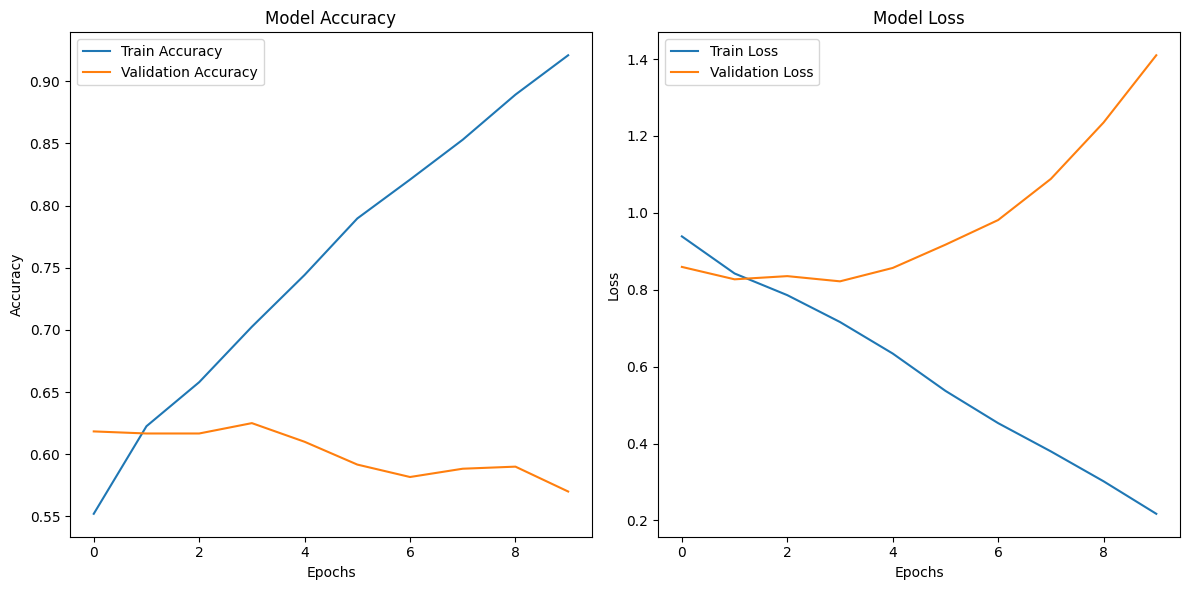

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy on the first subplot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss on the second subplot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
print(Y_test.shape)
print(y_pred_classes.shape)

(1421, 4)
(1421,)


In [ ]:
y_pred_labels = y_pred_classes

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from openpyxl import load_workbook
input_file = 'translated_youtube_data_2022.xlsx'
df = pd.read_excel(input_file)
comments = df.iloc[:, 0].tolist()

comments_list = []
sentiment_list = []
i=0
# Loop through each comment, preprocess, encode, and predict sentiment
for comment in comments:
    processed_comment = preprocess([comment])
    try:
        encoded_comment = encoding(processed_comment, Glove)  # Encode using GloVe
    except Exception as e:
        print(f"Error encoding comment {i}: {e}")
        comments_list.append(comment)
        sentiment_list.append('Unknown')
        continue
    i=i+1
    print(i)
    encoded_comment = np.array(encoded_comment)
    print(f"Encoded comment shape: {encoded_comment.shape}")
    # Predicting sentiment
    if encoded_comment.size == 0:
        print(f"Skipping comment due to empty encoding: {comment}")
        comments_list.append(comment)
        sentiment_list.append('Unknown')
        continue

    sentiment = model.predict(encoded_comment)[0]


    label = np.argmax(sentiment)
    comments_list.append(comment)
    sentiment_list.append(enc.categories_[0][label])

# Creating a DataFrame to save the results
output_df = pd.DataFrame({
    'Comment': comments_list,
    'Predicted Sentiment': sentiment_list
})

output_file = 'comment_sentiment_results_2022.xlsx'
output_df.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")

1
Encoded comment shape: (1, 52, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2
Encoded comment shape: (1, 2, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3
Encoded comment shape: (1, 6, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4
Encoded comment shape: (1, 5, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5
Encoded comment shape: (1, 0)
Skipping comment due to empty encoding: ✌
6
Encoded comment shape: (1, 4, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
7
Encoded comment shape: (1, 6, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
8
Encoded comment shape: (1, 3, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
9
Encoded comment shape: (1, 3, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
10
Encoded comment shape: (1, 2, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
11
Encoded comment shape: (1, 42, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
12
Encoded comment shape: (1, 3, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13
Encoded comment shape: (1, 10, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
14
Encoded comment shape: (1, 3

In [ ]:
import pandas as pd

# the file paths for each year's data
file_2017 = 'comment_sentiment_results_2017.xlsx'
file_2020 = 'comment_sentiment_results_2020.xlsx'
file_2022 = 'comment_sentiment_results_2022.xlsx'
file_2024 = 'comment_sentiment_results.xlsx'

df_2017 = pd.read_excel(file_2017)
df_2020 = pd.read_excel(file_2020)
df_2022 = pd.read_excel(file_2022)
df_2024 = pd.read_excel(file_2024)

df_2017['Year'] = 2017
df_2020['Year'] = 2020
df_2022['Year'] = 2022
df_2024['Year'] = 2024

# Combining the data
df_combined = pd.concat([df_2017, df_2020, df_2022, df_2024], ignore_index=True)
df_combined.head()



,Comment,Predicted Sentiment,Year
0,Send video in sir hindi tanku sir ji,joy,2017
1,i am proud because the total asset and budget...,sadness,2017
2,shocked to see the gundagiri of congress membe...,sadness,2017
3,plz explain what steps have been taken by Indi...,sadness,2017
4,Mukesh pandit,joy,2017


In [ ]:
df_combined.rename(columns={'Predicted Sentiment': 'Emotion'}, inplace=True)
print(df_combined.columns)

Index(['Comment', 'Emotion', 'Year'], dtype='object')


In [ ]:
# Group by Year and Emotion, then count occurrences
emotion_data = df_combined.groupby(['Year', 'Emotion']).size().reset_index(name='Count')
pivot_df = emotion_data.pivot(index='Year', columns='Emotion', values='Count').fillna(0)
pivot_df.head()

Emotion,Unknown,anger,fear,joy,sadness
Year,,,,,
2017,1.0,25.0,83.0,100.0,110.0
2020,9.0,12.0,39.0,51.0,93.0
2022,18.0,20.0,72.0,118.0,92.0
2024,0.0,61.0,52.0,41.0,66.0


<Figure size 1000x600 with 0 Axes>

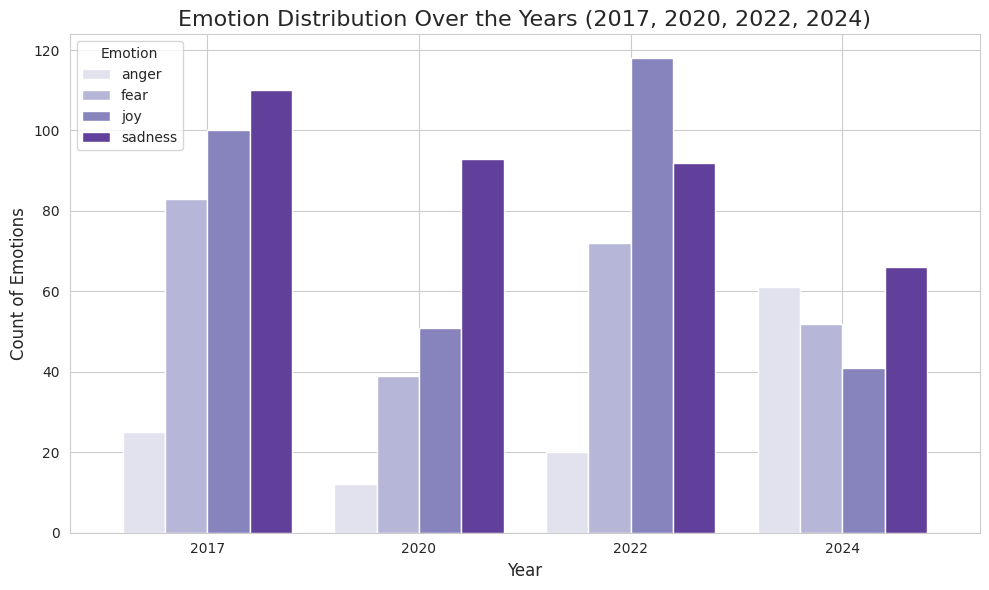

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_combined[df_combined['Emotion'] != 'Unknown']
emotion_data = df_filtered.groupby(['Year', 'Emotion']).size().reset_index(name='Count')

#for visualization
pivot_df = emotion_data.pivot(index='Year', columns='Emotion', values='Count').fillna(0)
purple_palette = sns.color_palette("Purples", n_colors=len(pivot_df.columns))
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6), color=purple_palette, width=0.8)
plt.title('Emotion Distribution Over the Years (2017, 2020, 2022, 2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count of Emotions', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Emotion', loc='upper left')

plt.tight_layout()
plt.show()
